<a href="https://colab.research.google.com/github/alvlagus/PyTorch_GB/blob/Lesson_4/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Hw_4_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align='center'><b>Фреймворк PyTorch для разработки искусственных нейронных сетей<b></h1>

<h2 align='center'>Урок 4. CNN Свертки</h2>

<h3 align='left'>Практическое задание:</h3>  

<ol>
        
<li>Обучите CNN (самописная) на CIFAR-100.</li>
<li>Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
</li>
<li>*Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.
</li> 
</ol>








# 1. Обучите CNN (самописная) на CIFAR-100.

## 1. Загрузка библиотек

In [ ]:
import numpy as np
import torch
import torchvision
import albumentations as alb

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import models


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## 2. Загрузка данных

In [ ]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

Files already downloaded and verified


## 3.  Создаем Dataset для загрузки данных

In [ ]:
class MyCifar100(Dataset):

    def __init__(self, init_dataset, transform=None) -> None:
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, index):
        img = self._base_dataset[index][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[index][1]

In [ ]:
# добавляем трансформацию, увеличивая изображение до 44 пикселей и рандомно вырезая 32 пикселя, с добавлением паддинга
trans_actions = transforms.Compose([transforms.Resize(44),  
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])  # ToTensor уже содержит нормализацию, поэтому отдельно не делаем

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=42)
    return X_train, X_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyCifar100(train_dataset, trans_actions)
valid_dataset = MyCifar100(valid_dataset, transforms.ToTensor())

## 4. Обернуть его в Dataloader

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

valid_loader = DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [ ]:
classes = [['beaver', 'dolphin', 'otter', 'seal', 'whale'],
              ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
              ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
              ['bottle', 'bowl', 'can', 'cup', 'plate'],
              ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
              ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
              ['bed', 'chair', 'couch', 'table', 'wardrobe'],
              ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
              ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
              ['bridge', 'castle', 'house', 'road', 'skyscraper'],
              ['cloud', 'forest', 'mountain', 'plain', 'sea'],
              ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
              ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
              ['crab', 'lobster', 'snail', 'spider', 'worm'],
              ['baby', 'boy', 'girl', 'man', 'woman'],
              ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
              ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
              ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
              ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
              ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']]

### Пример изображения

torch.Size([3, 32, 32])
93
turtle


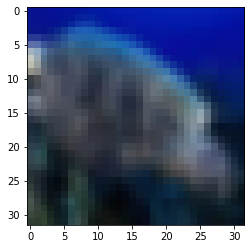

In [ ]:
image, label = train_dataset[42]
print(image.size())
print(label)
print(dataset.classes[label])
plt.imshow(image.permute(1, 2, 0))

Получаем устройство, на котором будем обучаться

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
class Net(nn.Module):


    def __init__(self) -> None:
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)

        self.bn_one = torch.nn.BatchNorm2d(3)  # бачнорм на входное количество каналов
        self.conv_one = torch.nn.Conv2d(3, 30, 3)  # конвалюция. Из 3х каналов делаем 30 
        self.bn_two = torch.nn.BatchNorm2d(30)  # бачнорм на 30 каналов
        self.conv_two = torch.nn.Conv2d(30, 60, 3)  # конвалюция. Из 30 каналов делаем 60 
        self.bn_three = torch.nn.BatchNorm2d(60)  # бачнорм на 60 каналов
        self.conv_three = torch.nn.Conv2d(60, 120, 3)  # конвалюция. Из 60 каналов делаем 120 
        self.bn_four = torch.nn.BatchNorm2d(120)  # бачнорм на 120 каналов
        self.fc1 = torch.nn.Linear(480, 200)  # слои для классификации исходные 480 значений, если изображение вытянуть в вектор
        self.fc2 = torch.nn.Linear(200, 60)  # постепенное уменьшение размерности до конечной классификации
        self.out = torch.nn.Linear(60, 100)

# соединяем слои вместе
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # pooling в инициализации не указывали, т.к. в нем нет весов

        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)

        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)

        return self.out(x)

net = Net().to(device)
print(net)   

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=100, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 200]          96,200
          Dropout-10                  [-1, 200]               0
           Linear-11                   [-1, 60]          12,060
           Linear-12                  [-1, 100]           6,100
Total params: 196,806
Trainable params: 196,806
Non-trainable params: 0
-------------------------------

In [ ]:
from IPython.utils.sysinfo import num_cpus
num_epochs = 5   # количество эпох
net.train()  # чтобы сеть обучалась

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)   # предсказание
        loss = criterion(outputs, labels)   # ошибка
        loss.backward()     # ошибка, подсчёт градиента
        optimizer.step()    # шаг оптимизации

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):

                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        net.train()

print('Training is finished')

Epoch [1/5]. Step [1/372]. Loss: 0.036. Acc: 0.008. Test acc: 0.012
Epoch [1/5]. Step [301/372]. Loss: 0.034. Acc: 0.033. Test acc: 0.051
Epoch [2/5]. Step [1/372]. Loss: 0.033. Acc: 0.039. Test acc: 0.046
Epoch [2/5]. Step [301/372]. Loss: 0.033. Acc: 0.051. Test acc: 0.064
Epoch [3/5]. Step [1/372]. Loss: 0.032. Acc: 0.039. Test acc: 0.059
Epoch [3/5]. Step [301/372]. Loss: 0.032. Acc: 0.062. Test acc: 0.071
Epoch [4/5]. Step [1/372]. Loss: 0.031. Acc: 0.109. Test acc: 0.074
Epoch [4/5]. Step [301/372]. Loss: 0.031. Acc: 0.076. Test acc: 0.074
Epoch [5/5]. Step [1/372]. Loss: 0.032. Acc: 0.023. Test acc: 0.080
Epoch [5/5]. Step [301/372]. Loss: 0.031. Acc: 0.088. Test acc: 0.084
Training is finished


**Вывод:**  
Я обучил рукописную сеть CNN на датасете  CIFAR100.<br>
Сеть состоит из 12 слоёв, в том числе: 2 слоя Dropout, 3 Conv2d и 4 BatchNorm2d. 
Также применялись функции активации активации relu и leaky_relu. Для уменьшения размерности изображения применял pool2d. 
Исходное изображение из 3х каналов увеличивалось до 120, затем вытягивалось в вектор с 480 значениями, а дальше уменьшалось до искомых 100.




# 2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [ ]:
resnet50 = models.resnet50(pretrained=True)
print(resnet50) 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [ ]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [ ]:
resnet50 = resnet50.to(device)

In [ ]:
trans_actions = transforms.Compose([transforms.Resize(size=(255, 255), ),  
                                    transforms.RandomRotation(degrees=90),
                                    transforms.ColorJitter(brightness=2, contrast=2),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyCifar100(train_dataset, trans_actions)
valid_dataset = MyCifar100(valid_dataset, valid_transforms)

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

valid_loader = DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [ ]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
%%time

num_epochs = 5   # количество эпох
resnet50.train()  # чтобы сеть обучалась

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)   # предсказание
        loss = criterion(outputs, labels)   # ошибка
        loss.backward()     # ошибка, подсчёт градиента
        optimizer.step()    # шаг оптимизации

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):

                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()

print('Training is finished')

Epoch [1/5]. Step [1/372]. Loss: 0.036. Acc: 0.023. Test acc: 0.014
Epoch [1/5]. Step [301/372]. Loss: 0.031. Acc: 0.129. Test acc: 0.281
Epoch [2/5]. Step [1/372]. Loss: 0.026. Acc: 0.203. Test acc: 0.291
Epoch [2/5]. Step [301/372]. Loss: 0.026. Acc: 0.203. Test acc: 0.385
Epoch [3/5]. Step [1/372]. Loss: 0.028. Acc: 0.180. Test acc: 0.371
Epoch [3/5]. Step [301/372]. Loss: 0.026. Acc: 0.222. Test acc: 0.394
Epoch [4/5]. Step [1/372]. Loss: 0.025. Acc: 0.234. Test acc: 0.392
Epoch [4/5]. Step [301/372]. Loss: 0.025. Acc: 0.235. Test acc: 0.402
Epoch [5/5]. Step [1/372]. Loss: 0.024. Acc: 0.266. Test acc: 0.390
Epoch [5/5]. Step [301/372]. Loss: 0.025. Acc: 0.246. Test acc: 0.444
Training is finished
CPU times: user 9min 16s, sys: 42.8 s, total: 9min 59s
Wall time: 19min 7s


**Вывод:**  
Я обучил предобученную сеть CNN resnet50 на датасете  CIFAR100.<br>
Был заменен последний слой resnet50.fc = nn.Linear(2048, 100). 
ТАкже была применена аугментация данных.